# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [195]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import math

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [196]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_max = 256
valor_min = 0
valores_color = 3
num_colores = 100
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))

## SOM Setup
#### Variables definidas por el alumno

In [197]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 20 # 7
periodo = 300
learning_rate = 0.1
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [198]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_color
num_datos = num_colores

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = int(lado_mapa/2)

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    #datos = preprocessing.normalize(datos)
    datos = datos / 255
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random((lado_mapa,lado_mapa,valores_color))

#### Funciones para entrenar/clasificar

In [199]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
   rows = len(m_pesos)
   columns = len(m_pesos[0])
   vectorPesos =  []
   ganadora = 2000
   for x in range(rows):
      for y in range(columns):
         for z in range(m):
            vectorPesos.append(m_pesos[x][y][z])
         dist = np.linalg.norm(np.array(vectorPesos - patron_entrada))
         if dist < ganadora:
            ganadora = dist
            Bmu = vectorPesos
            BmuIndex = np.stack((x,y))
         vectorPesos = []
   return Bmu , BmuIndex

In [200]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   learning_rate = lr_inicial * (1 - i/n_iteraciones)
   return learning_rate


In [201]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   vecindario = 1 + vecindario_inicial * (1 - i/n_iteraciones)
   return vecindario
   

In [202]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

In [203]:
#Funcion Ajuste de matriz de pesos
def ajustarPesos(IndexN, color , learning_rate , matriz_pesos, vecindario_actual):
    #Cambiamos el peso de la neurona dada por el BMU
    '''
    matriz_pesos[IndexN[0]][IndexN[1]] = matriz_pesos[IndexN[0]][IndexN[1]] + (learning_rate * (color - matriz_pesos[IndexN[0]][IndexN[1]]))
    '''
    #ajustamos las neuronas adyacentes usando decay()
    veci = vecindario_actual # variable vecindario
    '''
    print("vecindario: ",veci)
    izq = False
    der = False 
    arr = False 
    abj = False
    #izquiera (-1, 0)
    if (IndexN[0]-veci) >= 0: # el indice menos el numero de neuronas adyacente debe ser mayor o igual que 0
        izq = True # se puede avanzar hacia la izquierda
    #derecha (1,0)
    if (IndexN[0]+veci) < lado_mapa: 
        der = True 
    #arriba (0,1)
    if (IndexN[1]+veci) < lado_mapa: 
        arr = True 
    #abajo (0,-1)
    if (IndexN[1]-veci) >= 0: 
        abj = True 
    # el bucle se ejecuta 2 veces la longitud del vecindario mas 1 (el bmu) si izquierda y derecha son true, es decir, no se sale de la matriz
    # los if son: si uno de los dos booleanos son true escribimos 2xPosicionBMU+1 si no si alguno de los dos lo es escribimos 2xPosicionBMU y si ninguno lo es escribimos lo anterior -1 
    for j in range((2*veci) + 1 if izq and der else (2*veci) if izq or der else (2*veci - 1)): 
        indX = IndexN[0] - veci + j if izq else IndexN[0] - veci + j + 1 # posicion de la neurona BMU - valor del vecindario - elemento iterativo (se suma 1 si está en un límite)
        for k in range ((2*veci) + 1 if arr and abj else (2*veci) if arr or abj else (2*veci - 1)): # igual que el bucle superior ya que el objetivo es recorrer una matriz cuadrada
            indY = IndexN[1] - veci + k if abj else IndexN[1] - veci + k + 1
            if 0 <= indX < lado_mapa and 0 <= indY < lado_mapa: # necesario a pesar de tratar de calcularlo "a mano" ya que no se contaba con que se saliese de la matriz por mas de un valor
                dist = np.linalg.norm(np.array(IndexN) - np.array([indX, indY]))
                a = decay(dist, veci)
                # aqui actualizamos la matriz de pesos en la neurona indX, indY
                matriz_pesos[indX,indY] = matriz_pesos[indX,indY] + (learning_rate * a *(color - matriz_pesos[indX,indY]))
                
    return matriz_pesos
    '''
    #'''
    # Situamos las nuevas coordenadas en la esquina izquierda del vecindario de las coordenadas dadas
    indX = IndexN[0] - veci
    indY = IndexN[1] - veci
    # Se comprueba si estan o no fuera de la matriz de pesos
    for i in range(int(2*veci + 1)):
        for j in range(int(2*veci + 1)):
            indX = int(IndexN[0] - veci + i )
            indY = int(IndexN[1] - veci + j)
            if 0 <= indX < lado_mapa and 0 <= indY < lado_mapa: # si esta dentro del rango de la matriz de pesos:
                dist = np.linalg.norm(np.array(IndexN) - np.array([indX, indY]))
                a = decay(dist, veci)
                # aqui actualizamos la matriz de pesos en la neurona indX, indY
                matriz_pesos[indX,indY] = matriz_pesos[indX,indY] + (learning_rate * a *(color - matriz_pesos[indX,indY]))

    return matriz_pesos
    #'''
'''
elemento = []
elemento.append(np.random.randint(0,7))
elemento.append(np.random.randint(0,7))
print(elemento)
ajustarPesos(elemento)
'''

'\nelemento = []\nelemento.append(np.random.randint(0,7))\nelemento.append(np.random.randint(0,7))\nprint(elemento)\najustarPesos(elemento)\n'

#### Funciones para dibujar la salida de la red

In [204]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento

100
200
300
[2 4]  <-traducido- [ 1 , 3 ]
[7 3]  <-traducido- [ 6 , 2 ]
[3 5]  <-traducido- [ 2 , 4 ]
[4 6]  <-traducido- [ 3 , 5 ]
[3 1]  <-traducido- [ 2 , 0 ]
[3 7]  <-traducido- [ 2 , 6 ]
[7 7]  <-traducido- [ 6 , 6 ]
[7 4]  <-traducido- [ 6 , 3 ]
[2 6]  <-traducido- [ 1 , 5 ]
[7 5]  <-traducido- [ 6 , 4 ]
[1 3]  <-traducido- [ 0 , 2 ]
[2 1]  <-traducido- [ 1 , 0 ]
[6 3]  <-traducido- [ 5 , 2 ]
[2 2]  <-traducido- [ 1 , 1 ]
[4 2]  <-traducido- [ 3 , 1 ]
[2 7]  <-traducido- [ 1 , 6 ]
[7 2]  <-traducido- [ 6 , 1 ]
[7 1]  <-traducido- [ 6 , 0 ]
[2 5]  <-traducido- [ 1 , 4 ]
[3 6]  <-traducido- [ 2 , 5 ]
[6 2]  <-traducido- [ 5 , 1 ]
[5 7]  <-traducido- [ 4 , 6 ]
[6 7]  <-traducido- [ 5 , 6 ]
[1 7]  <-traducido- [ 0 , 6 ]
[1 1]  <-traducido- [ 0 , 0 ]
[7 6]  <-traducido- [ 6 , 5 ]
[6 1]  <-traducido- [ 5 , 0 ]
[4 1]  <-traducido- [ 3 , 0 ]
[5 1]  <-traducido- [ 4 , 0 ]
[3 2]  <-traducido- [ 2 , 1 ]
[1 5]  <-traducido- [ 0 , 4 ]
[1 2]  <-traducido- [ 0 , 1 ]
[1 4]  <-traducido- [ 0 , 3 

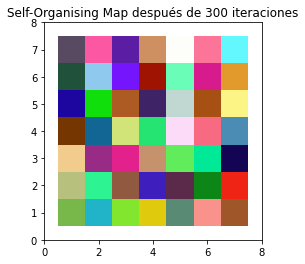

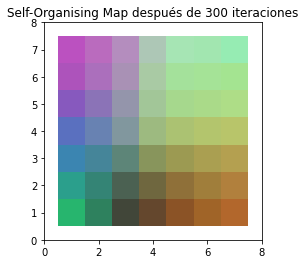

In [205]:
# Entrena la red con el dataset de entrenamiento
matriz_pesos_orig = matriz_pesos.copy()
datosT = np.transpose(datos)
listabmu = []
listabmu.append([-1,-1])
learning_rate_actual = learning_rate
vecindario_actual = vecindario
for x in range(periodo):
    if((x+1) % 100 == 0):
        print(x+1)
    numAleatorio = np.random.randint(0, num_colores)
    color = datosT[numAleatorio]
    Bmu , BmuIndex = calcular_bmu(color,matriz_pesos,valores_color)
    #creacion de la lista de indexes usados
    isNotInListIndex = True
    for index in listabmu:
        if index[0] == BmuIndex[0] and index[1] == BmuIndex[1]:
            isNotInListIndex = False
    if isNotInListIndex:
        listabmu.append(BmuIndex)
    #Algoritmo de aprendizaje:
    #print(matriz_pesos[BmuIndex[0]][BmuIndex[1]])
    matriz_pesos = ajustarPesos(BmuIndex , color , learning_rate_actual , matriz_pesos, vecindario_actual).copy()
    #print(matriz_pesos[BmuIndex[0]][BmuIndex[1]])
    learning_rate_actual = variacion_learning_rate(learning_rate, x, periodo)
    vecindario_actual = variacion_vecindario(vecindario, x, periodo)

#Muestro los indexes usados:
for bmuIndex in listabmu: 
    if bmuIndex[0] != -1 and bmuIndex[1] != -1:
        print(bmuIndex + 1, " <-traducido- [",bmuIndex[0],",",bmuIndex[1],"]")
#pinto mapa antiguo y nuevo para comparar
pintar_mapa(matriz_pesos_orig)
pintar_mapa(matriz_pesos)

## SOM Clasificación

In [206]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada



## SOM Prueba

In [207]:
# Clasifica nuevos patrones

